## LSTM for crude oir price prediction


In [1]:
# In order to obtain the correct values for "credentias", "bucket_name" and "endpoint" 
# please follow the tutorial at https://github.com/IBM/skillsnetwork/wiki/Cloud-Object-Storage-Setup

credentials = {
  "apikey": "RHPLuwaEctTZ68Ne8FwoHZaXKujcdzApQEgCauExsIbC",
  "cos_hmac_keys": {
    "access_key_id": "a89357bb879e4a59aa015abffb144827",
    "secret_access_key": "0d78e16cbb6fe96d6f3b55dca4c7f9b6d03ece26626b1cc3"
  },
  "endpoints": "https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints",
  "iam_apikey_description": "Auto-generated for key a89357bb-879e-4a59-aa01-5abffb144827",
  "iam_apikey_name": "Service credentials-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/3dba62a148ab4574867f8eb140c3a44e::serviceid:ServiceId-109769b1-d4d5-4997-93a1-faefc036bfa9",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/3dba62a148ab4574867f8eb140c3a44e:643e3143-6265-453a-877a-15ae3947ef9a::"
}

bucket_name = "cloud-object-storage-appliedaideeplearning"
endpoint = "https://s3.eu-de.cloud-object-storage.appdomain.cloud"

In [2]:
import base64
from ibm_botocore.client import Config
import ibm_boto3
import time

# Create client 
client = ibm_boto3.client(
    's3',
    aws_access_key_id = credentials["cos_hmac_keys"]['access_key_id'],
    aws_secret_access_key = credentials["cos_hmac_keys"]["secret_access_key"],
    endpoint_url=endpoint
)

client.download_file(bucket_name, 'DCOILBRENTEU.csv', 'DCOILBRENTEU.csv')

In [5]:
import pandas as pd

df_data_1 = pd.read_csv('DCOILBRENTEU.csv')
print(df_data_1.shape)
df_data_1.head()

(8989, 2)


,DATE,DCOILBRENTEU
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


Data Source
-----------
U.S. Energy Information Administration, Crude Oil Prices: Brent - Europe [DCOILBRENTEU], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DCOILBRENTEU, January 10, 2018.

In [6]:
df_data_1 = df_data_1[df_data_1.DCOILBRENTEU != "."]
print(df_data_1.shape)

(8747, 2)


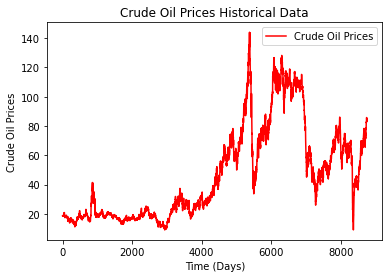

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

df_data_1_plot = df_data_1.iloc[:, 1:2].values.astype(float)
# Visualising the Data
plt.plot(df_data_1_plot, color = 'red', label = 'Crude Oil Prices')
plt.title('Crude Oil Prices Historical Data')
plt.xlabel('Time (Days)')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

Stateful vs. Stateless LSTM
--------------------------

1. **Stateless**: LSTM updates parameters on **batch 1** and then initiates cell states (meaning - memory, usually with zeros) for **batch 2** 
2. **Stateful**: it uses batch 1 last output cell sates as initial states for batch 2.

When to use which?
----------------

- When  sequences in batches are related to each other (e.g. prices of one commodity), we should better use **stateful** mode
- Else, when one sequence represents a complete sentence, we  should go with **stateless** mode

Batch-size: which batch-size to choose?
------------------------------------

**Very important decision!**

Imagine, you must learn to recognize a bird...
You are presented images of different birds.

What would you prefer:
1. To see the one image at a time, make your notes about special bird qualities (set your **weights**) and then see another bird and so on
2. **OR** may be you would better learn if you see - let's say 5 - bird images at ones. May be then you can faster notice the bird's intrinsic properties?

I'd say - the second method is more efficient for humans. We need more examples of an entitiy, that we have to distinguish. 

**So the machines! Therefore we select a batch size of 64.
Later in programming assigment we will see how the batch size impacts the prediction accuracy.**

In [9]:
#import packages
import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import load_model

In [27]:
# defining the batch size and number of epochs
batch_size = 64
epochs = 120 # 1 epoch: a training round
timesteps = 10 # LSTM will learn from timesteps in the past, to predict timesteps in the future. Here 1 timestep = 1 day. 

Batch-size and trainings-set size
-------------------------------

With **stateful LSTMs** the trainings-set size must be divisible without remainder by the batch-size (modulo = 0)

In [11]:
length = len(df_data_1)
print(length)
length *= 1 - 0.1
print(length)

8747
7872.3


In [12]:
7872.3 % 64.0

0.3000000000001819

In [19]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    print(length, int(length) - 100, int(length))
    for x in range(int(length) - 100, int(length)): 
        modulo = x % batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print(x)
    return (max(train_length_values))

In [20]:
length = get_train_length(df_data_1, batch_size, 0.1)
print(length)

7872.3 7772 7872
7808
7808


In [15]:
7808 % 64.0

0.0

Construct input and output data for LSTM
-------------------------------

In [28]:
#Adding timesteps * 2
upper_train = length + timesteps*2
df_data_1_train = df_data_1[0:upper_train]
training_set = df_data_1_train.iloc[:,1:2].values
print(training_set.shape)
print(training_set)

(7828, 1)
[['18.63']
 ['18.45']
 ['18.55']
 ...
 ['64.68']
 ['64.82']
 ['66.0']]


In [29]:
# Feature Scaling
# scale between 0 and 1. The weights are easier to find.
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
print(training_set_scaled.shape)
print(training_set_scaled)

(7828, 1)
[[0.07067112]
 [0.0693363 ]
 [0.07007786]
 ...
 [0.41216166]
 [0.41319985]
 [0.42195032]]


In [30]:
X_train = []
y_train = []

# Creating a data structure with n timesteps

print(length + timesteps)
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

print(len(X_train))
print(len(y_train))
#create X_train matrix
#30 items per array (timestep) 
print(X_train[0:2])
print(np.array(X_train).shape)
#create Y_train matrix
#30 items per array (timestep) 
print(y_train[0:2])
print(np.array(y_train).shape)

7818
7808
7808
[array([0.07067112, 0.0693363 , 0.07007786, 0.07044865, 0.07067112,
       0.07044865, 0.07044865, 0.07030033, 0.07081943, 0.0710419 ]), array([0.0693363 , 0.07007786, 0.07044865, 0.07067112, 0.07044865,
       0.07044865, 0.07030033, 0.07081943, 0.0710419 , 0.07156099])]
(7808, 10)
[array([0.07156099, 0.07178346, 0.07081943, 0.07156099, 0.07178346,
       0.07178346, 0.0710419 , 0.07178346, 0.07267334, 0.07363737]), array([0.07178346, 0.07081943, 0.07156099, 0.07178346, 0.07178346,
       0.0710419 , 0.07178346, 0.07267334, 0.07363737, 0.07378569])]
(7808, 10)


In [31]:
# Reshaping
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # shape: (length, timesteps, features)
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(7808, 10, 1)
(7808, 10, 1)


In [32]:
# Building the LSTM
# Importing the Keras libraries and packages

from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.models import Model
import h5py

In [35]:
# Initialising the LSTM Model with MAE Loss-Function
# Using Functional API

inputs_1_mae = Input(batch_shape = (batch_size, timesteps, 1)) # 1 feature (dimension): crude oil price
#each layer is the input of the next layer
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units=1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs=output_1_mae)

#adam is fast starting off and then gets slower and more precise
#mae -> mean absolute error loss function
regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 10, 1)]             0         
_________________________________________________________________
lstm (LSTM)                  (64, 10, 10)              480       
_________________________________________________________________
lstm_1 (LSTM)                (64, 10, 10)              840       
_________________________________________________________________
dense (Dense)                (64, 10, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# #some learners constantly reported 502 errors in Watson Studio. 
# #This is due to the limited resources in the free tier and the heavy resource consumption of Keras.
# #This is a workaround to limit resource consumption

# from keras import backend as K

# K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))


How LSTM Param Number is computed?
--------------------------------

1. To decide how to handle the memory each LSTM Cell has <bold>3 Gates</bold>:
    - input (what to let in), 
    - forget (what to forget) and 
    - output (what to write to the output)
2. LSTM **Cell State** is its **memory**
3. LSTM Hidden State is equivalent to the Cell output:
    - lstm_hidden_state_size (number of neurons = memory cells) = lstm_outputs_size
4. Parameters:
    - weights for the inputs (lstm_inputs_size)
    - weights for the outputs (lstm_outputs_size)
    - bias variable
5.  Result from previous point - for all 3 Gates and for Cell State ( = 4)  
   
    \begin{equation}
          \textbf{PARAMETERS} = \textbf4 \times \textbf{ LSTM outputs size} \times (\textbf{weights LSTM inputs size} + \textbf{weights LSTM outputs size} + 1 \textbf{ bias variable})
    \end{equation}
    

In [36]:
# 1st LSTM Layer
parameters = 4 * 10 * (1 + 10 + 1)
print(parameters)

480


In [37]:
# 2nd LSTM Layer
parameters = 4 * 10 * (10 + 10 + 1)
print(parameters)

840


In [38]:
#Statefull
for i in range(epochs):
    print("Epoch: " + str(i))
    #run through all data but the cell, hidden state are used for the next batch.
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    #resets only the states but the weights, cell and hidden are kept.
    regressor_mae.reset_states()
    
#Stateless
#between the batches the cell and hidden states are lost.
#regressor_mae.fit(X_train, y_train, shuffle=False, epochs = epochs, batch_size = batch_size)

Epoch: 0
122/122 [==============================] - 1s 6ms/step - loss: 0.0448
Epoch: 1
122/122 [==============================] - 1s 6ms/step - loss: 0.0477
Epoch: 2
122/122 [==============================] - 1s 6ms/step - loss: 0.0434
Epoch: 3
122/122 [==============================] - 1s 5ms/step - loss: 0.0433
Epoch: 4
122/122 [==============================] - 1s 6ms/step - loss: 0.0441
Epoch: 5
122/122 [==============================] - 1s 6ms/step - loss: 0.0462
Epoch: 6
122/122 [==============================] - 1s 6ms/step - loss: 0.0478
Epoch: 7
122/122 [==============================] - 1s 6ms/step - loss: 0.0482
Epoch: 8
122/122 [==============================] - 1s 6ms/step - loss: 0.0481
Epoch: 9
122/122 [==============================] - 1s 6ms/step - loss: 0.0478
Epoch: 10
122/122 [==============================] - 1s 6ms/step - loss: 0.0471
Epoch: 11
122/122 [==============================] - 1s 5ms/step - loss: 0.0466
Epoch: 12
122/122 [==============================]

122/122 [==============================] - 1s 5ms/step - loss: 0.0222
Epoch: 103
122/122 [==============================] - 1s 5ms/step - loss: 0.0217
Epoch: 104
122/122 [==============================] - 1s 5ms/step - loss: 0.0224
Epoch: 105
122/122 [==============================] - 1s 5ms/step - loss: 0.0216
Epoch: 106
122/122 [==============================] - 1s 5ms/step - loss: 0.0221
Epoch: 107
122/122 [==============================] - 1s 5ms/step - loss: 0.0212
Epoch: 108
122/122 [==============================] - 1s 5ms/step - loss: 0.0215
Epoch: 109
122/122 [==============================] - 1s 5ms/step - loss: 0.0211
Epoch: 110
122/122 [==============================] - 1s 5ms/step - loss: 0.0215
Epoch: 111
122/122 [==============================] - 1s 5ms/step - loss: 0.0212
Epoch: 112
122/122 [==============================] - 1s 5ms/step - loss: 0.0216
Epoch: 113
122/122 [==============================] - 1s 5ms/step - loss: 0.0214
Epoch: 114
122/122 [===================

In [39]:
#save model
regressor_mae.save(filepath="my_model_with_mae_timesteps_10.h5")

In [40]:
#load model
import h5py
regressor_mae = load_model(filepath="my_model_with_mae_timesteps_10.h5")

In [41]:
regressor_mae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 10, 1)]             0         
_________________________________________________________________
lstm (LSTM)                  (64, 10, 10)              480       
_________________________________________________________________
lstm_1 (LSTM)                (64, 10, 10)              840       
_________________________________________________________________
dense (Dense)                (64, 10, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________
